In [6]:
import boto3
import pandas as pd

import os
from io import StringIO

pd.set_option("display.max_columns", 50)

import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
aws_access_key = os.getenv("AWS_ACCESS_KEY")
aws_secret_key = os.getenv("AWS_SECRET_KEY")

In [8]:
def read_csv_from_s3(bucket:str, path:str, filename:str) -> pd.DataFrame:
    """
    Downloads a csv file from an S3 bucket.
    
    Parameters:
    - bucket (str): Contains the name of the bucket.
    - path (str): Contains the name of the folder of the csv file.
    . filename (str): Contains the name of the csv file.
    
    Returns:
    - output_df (pd.DataFrame): Contains the content of the csv file.
    """
    
    s3 = boto3.client("s3", aws_access_key_id = aws_access_key, aws_secret_access_key = aws_secret_key)
    full_path = f"{path}{filename}"
    object = s3.get_object(Bucket = bucket, Key = full_path)
    object = object["Body"].read().decode("utf-8")
    output_df = pd.read_csv(StringIO(object))
    
    return output_df

In [9]:
s3 = boto3.client("s3", aws_access_key_id = aws_access_key, aws_secret_access_key = aws_secret_key)
bucket = "cubix-chicago-taxi-zh"

payment_type_path = "transformed_data/payment_type/"
community_areas_path = "transformed_data/community_areas/"
company_path = "transformed_data/company/"
date_path = "transformed_data/date/"
taxi_path = "transformed_data/taxi_trips/"
weather_path = "transformed_data/weather/"

payment_type_master = read_csv_from_s3(bucket = bucket, path = payment_type_path, filename = "payment_type_master.csv")
community_areas_master = read_csv_from_s3(bucket = bucket, path = community_areas_path, filename = "community_areas_master.csv")
company_master = read_csv_from_s3(bucket = bucket, path = company_path, filename = "company_master.csv")
date_dimension = read_csv_from_s3(bucket = bucket, path = date_path, filename = "date_dimension.csv")


In [10]:
trips_list = []
weather_list = []

In [11]:
# TAXI DATA TRANSFORMING AND LOADING
for file in s3.list_objects(Bucket = bucket, Prefix = taxi_path)["Contents"]:
    taxi_key = file["Key"]
        
    if taxi_key.split("/")[-1].strip() != "":
        if taxi_key.split(".")[1].strip() == "csv":
                
            filename = taxi_key.split("/")[-1]
            trip = read_csv_from_s3(bucket, taxi_path, filename)
            trips_list.append(trip)
            print(filename, " has been added.")



taxi_2024-06-24.csv  has been added.
taxi_2024-06-25.csv  has been added.
taxi_2024-06-26.csv  has been added.
taxi_2024-06-27.csv  has been added.
taxi_2024-06-28.csv  has been added.
taxi_2024-06-29.csv  has been added.
taxi_2024-06-30.csv  has been added.
taxi_2024-07-01.csv  has been added.


In [12]:
trips_df = pd.concat(trips_list, ignore_index = True)

trips_df.head()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area_id,dropoff_community_area_id,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,payment_type_id,company_id
0,dd4f31c2d8282bde5920d4af0c9d776020b1fd80,e62d04043f2fc77336b984477a11a2de252c515042c8da...,2024-06-24T23:45:00.000,2024-06-24T23:45:00.000,268,0.50,8,8,4.50,3.00,0.0,1.0,9.00,41.899602,-87.633308,41.899602,-87.633308,2024-06-24 23:00:00,1,1
1,d5b01000f4ece73f264cea05c6df2fd1dfc80925,f6d4ccd11c7def8e9b0a7cbfea8c9b1a733540a60eea28...,2024-06-24T23:45:00.000,2024-06-25T00:00:00.000,973,12.98,76,7,32.75,0.00,0.0,4.0,36.75,41.980264,-87.913625,41.922686,-87.649489,2024-06-24 23:00:00,2,2
2,d49e3bc3211a1f0cbe3c3a72d3f083d7a5be8732,0bea3de3c36237d68b009b24ee3db86c78e9e618a73a3b...,2024-06-24T23:45:00.000,2024-06-25T00:15:00.000,1620,14.30,56,6,37.25,10.40,0.0,4.0,51.65,41.792592,-87.769615,41.944227,-87.655998,2024-06-24 23:00:00,1,3
3,d3a3b47006124027a70cb2229dcf602f921888ee,dec67a4fc6ba6a0b279c4f8ebaba8c9c160e469d03cb20...,2024-06-24T23:45:00.000,2024-06-25T00:00:00.000,1093,8.06,2,10,22.00,0.00,0.0,0.0,22.00,42.001571,-87.695013,41.985015,-87.804532,2024-06-24 23:00:00,3,2
4,ceb3bb0e8df99fef703ea0585e6bb0b342e99a49,3cf614bd7410ac2d0334dd9e1275a2d1c5a3ede41a98a5...,2024-06-24T23:45:00.000,2024-06-25T00:15:00.000,1440,17.20,76,32,42.75,9.35,0.0,4.0,56.10,41.979071,-87.903040,41.884987,-87.620993,2024-06-24 23:00:00,1,3


In [13]:
# WEATHER DATA TRANSFORMING AND LOADING
for file in s3.list_objects(Bucket = bucket, Prefix = weather_path)["Contents"]:
    weather_key = file["Key"]
        
    if weather_key.split("/")[-1].strip() != "":
        if weather_key.split(".")[1].strip() == "csv":
                
            filename = weather_key.split("/")[-1]
            weather = read_csv_from_s3(bucket, weather_path, filename)
            weather_list.append(weather)
            print(filename, " has been added.")
                

weather_2024-06-24.csv  has been added.
weather_2024-06-25.csv  has been added.
weather_2024-06-26.csv  has been added.
weather_2024-06-27.csv  has been added.
weather_2024-06-28.csv  has been added.
weather_2024-06-29.csv  has been added.
weather_2024-06-30.csv  has been added.
weather_2024-07-01.csv  has been added.


In [14]:
weather_df = pd.concat(weather_list, ignore_index = True)

weather_df.head()

,datetime,temperature,wind_speed,rain,precipitation
0,2024-06-24 00:00:00,21.8,10.6,0.0,0.0
1,2024-06-24 01:00:00,21.8,3.3,0.0,0.0
2,2024-06-24 02:00:00,21.6,3.6,0.0,0.0
3,2024-06-24 03:00:00,21.4,4.8,0.0,0.0
4,2024-06-24 04:00:00,21.1,8.0,0.0,0.0


In [15]:
payment_type_master.head()

,payment_type_id,payment_type
0,1,Credit Card
1,2,Cash
2,3,Prcard
3,4,No Charge
4,5,Mobile


In [16]:
community_areas_master.head()

,area_code,community_name
0,1,Rogers Park
1,2,West Ridge
2,3,Uptown
3,4,Lincoln Square
4,5,North Center


In [17]:
company_master.head()

,company_id,company
0,1,Top Cab
1,2,Flash Cab
2,3,Taxi Affiliation Services
3,4,5 Star Taxi
4,5,Sun Taxi


In [18]:
date_dimension.head()

,date,year,month,day,day_of_week,is_weekend
0,2023-01-01,2023,1,1,7,True
1,2023-01-02,2023,1,2,1,False
2,2023-01-03,2023,1,3,2,False
3,2023-01-04,2023,1,4,3,False
4,2023-01-05,2023,1,5,4,False


# Data Model

In [19]:
trips_full = pd.merge(trips_df, weather_df, left_on = "datetime_for_weather", right_on = "datetime", how = "inner")
trips_full = trips_full.drop(["datetime"], axis = 1)

trips_full.head()



,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area_id,dropoff_community_area_id,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,payment_type_id,company_id,temperature,wind_speed,rain,precipitation
0,dd4f31c2d8282bde5920d4af0c9d776020b1fd80,e62d04043f2fc77336b984477a11a2de252c515042c8da...,2024-06-24T23:45:00.000,2024-06-24T23:45:00.000,268,0.50,8,8,4.50,3.00,0.0,1.0,9.00,41.899602,-87.633308,41.899602,-87.633308,2024-06-24 23:00:00,1,1,26.9,20.0,0.0,0.0
1,d5b01000f4ece73f264cea05c6df2fd1dfc80925,f6d4ccd11c7def8e9b0a7cbfea8c9b1a733540a60eea28...,2024-06-24T23:45:00.000,2024-06-25T00:00:00.000,973,12.98,76,7,32.75,0.00,0.0,4.0,36.75,41.980264,-87.913625,41.922686,-87.649489,2024-06-24 23:00:00,2,2,26.9,20.0,0.0,0.0
2,d49e3bc3211a1f0cbe3c3a72d3f083d7a5be8732,0bea3de3c36237d68b009b24ee3db86c78e9e618a73a3b...,2024-06-24T23:45:00.000,2024-06-25T00:15:00.000,1620,14.30,56,6,37.25,10.40,0.0,4.0,51.65,41.792592,-87.769615,41.944227,-87.655998,2024-06-24 23:00:00,1,3,26.9,20.0,0.0,0.0
3,d3a3b47006124027a70cb2229dcf602f921888ee,dec67a4fc6ba6a0b279c4f8ebaba8c9c160e469d03cb20...,2024-06-24T23:45:00.000,2024-06-25T00:00:00.000,1093,8.06,2,10,22.00,0.00,0.0,0.0,22.00,42.001571,-87.695013,41.985015,-87.804532,2024-06-24 23:00:00,3,2,26.9,20.0,0.0,0.0
4,ceb3bb0e8df99fef703ea0585e6bb0b342e99a49,3cf614bd7410ac2d0334dd9e1275a2d1c5a3ede41a98a5...,2024-06-24T23:45:00.000,2024-06-25T00:15:00.000,1440,17.20,76,32,42.75,9.35,0.0,4.0,56.10,41.979071,-87.903040,41.884987,-87.620993,2024-06-24 23:00:00,1,3,26.9,20.0,0.0,0.0


In [20]:
trips_full = pd.merge(trips_full, company_master, left_on = "company_id", right_on = "company_id", how = "inner")
trips_full = trips_full.drop(["company_id"], axis = 1)

In [21]:
trips_full = pd.merge(trips_full, payment_type_master, left_on = "payment_type_id", right_on = "payment_type_id", how = "inner")
trips_full = trips_full.drop(["payment_type_id"], axis = 1)

In [22]:
trips_full = pd.merge(trips_full, community_areas_master, left_on = "pickup_community_area_id", right_on = "area_code", how = "inner")
trips_full = trips_full.drop(["pickup_community_area_id", "area_code"], axis = 1)
trips_full.rename(columns = {"community_name": "pickup_community_area_name"})

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,dropoff_community_area_id,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,temperature,wind_speed,rain,precipitation,company,payment_type,pickup_community_area_name
0,dd4f31c2d8282bde5920d4af0c9d776020b1fd80,e62d04043f2fc77336b984477a11a2de252c515042c8da...,2024-06-24T23:45:00.000,2024-06-24T23:45:00.000,268,0.50,8,4.50,3.00,0.0,1.0,9.00,41.899602,-87.633308,41.899602,-87.633308,2024-06-24 23:00:00,26.9,20.0,0.0,0.0,Top Cab,Credit Card,Near North Side
1,d5b01000f4ece73f264cea05c6df2fd1dfc80925,f6d4ccd11c7def8e9b0a7cbfea8c9b1a733540a60eea28...,2024-06-24T23:45:00.000,2024-06-25T00:00:00.000,973,12.98,7,32.75,0.00,0.0,4.0,36.75,41.980264,-87.913625,41.922686,-87.649489,2024-06-24 23:00:00,26.9,20.0,0.0,0.0,Flash Cab,Cash,O'Hare
2,d49e3bc3211a1f0cbe3c3a72d3f083d7a5be8732,0bea3de3c36237d68b009b24ee3db86c78e9e618a73a3b...,2024-06-24T23:45:00.000,2024-06-25T00:15:00.000,1620,14.30,6,37.25,10.40,0.0,4.0,51.65,41.792592,-87.769615,41.944227,-87.655998,2024-06-24 23:00:00,26.9,20.0,0.0,0.0,Taxi Affiliation Services,Credit Card,Garfield Ridge
3,d3a3b47006124027a70cb2229dcf602f921888ee,dec67a4fc6ba6a0b279c4f8ebaba8c9c160e469d03cb20...,2024-06-24T23:45:00.000,2024-06-25T00:00:00.000,1093,8.06,10,22.00,0.00,0.0,0.0,22.00,42.001571,-87.695013,41.985015,-87.804532,2024-06-24 23:00:00,26.9,20.0,0.0,0.0,Flash Cab,Prcard,West Ridge
4,ceb3bb0e8df99fef703ea0585e6bb0b342e99a49,3cf614bd7410ac2d0334dd9e1275a2d1c5a3ede41a98a5...,2024-06-24T23:45:00.000,2024-06-25T00:15:00.000,1440,17.20,32,42.75,9.35,0.0,4.0,56.10,41.979071,-87.903040,41.884987,-87.620993,2024-06-24 23:00:00,26.9,20.0,0.0,0.0,Taxi Affiliation Services,Credit Card,O'Hare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125602,f03b9da7f03b000bafb412b00453a98777aa8e55,4fdfda1ef9a53850fc350d2834bfd9086e4a622f5e06cd...,2024-06-30T00:00:00.000,2024-06-30T00:15:00.000,1048,10.79,32,28.00,20.00,0.0,4.0,52.50,41.785999,-87.750934,41.880994,-87.632746,2024-06-30 00:00:00,29.0,18.8,0.0,0.0,Medallion Leasin,Credit Card,Garfield Ridge
125603,f135b0016e469625475a220019347ecf53d321bf,04c44d1bf8cc741f86f8ccdee5b64b65e5a6631d743450...,2024-06-30T00:00:00.000,2024-06-30T00:15:00.000,565,0.00,8,14.00,0.00,0.0,0.0,14.00,41.944227,-87.655998,41.899602,-87.633308,2024-06-30 00:00:00,29.0,18.8,0.0,0.0,Flash Cab,Mobile,Lake View
125604,f15be67d446a92a2633fb3a4b9ff962a7e7b8c12,71d19421e844644dbbb38b1598fd85f794b9d37fa5f688...,2024-06-30T00:00:00.000,2024-06-30T00:30:00.000,1535,8.51,3,21.97,0.00,0.0,0.0,21.97,41.901207,-87.676356,41.965812,-87.655879,2024-06-30 00:00:00,29.0,18.8,0.0,0.0,Medallion Leasin,Mobile,West Town
125605,f4c621479c80b595441088105ffb90b79c25f850,018e2fc4d3e35a1f76f3221f8ecf824591aea4e6e7e05f...,2024-06-30T00:00:00.000,2024-06-30T00:15:00.000,923,3.19,24,9.39,0.00,1.0,0.0,10.39,41.922686,-87.649489,41.901207,-87.676356,2024-06-30 00:00:00,29.0,18.8,0.0,0.0,Sun Taxi,Mobile,Lincoln Park


In [23]:
trips_full = pd.merge(trips_full, community_areas_master, left_on = "dropoff_community_area_id", right_on = "area_code", how = "inner")
trips_full = trips_full.drop(["dropoff_community_area_id", "area_code"], axis = 1)
trips_full.rename(columns = {"community_name": "dropoff_community_area_name"})

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,temperature,wind_speed,rain,precipitation,company,payment_type,community_name_x,community_name_y
0,dd4f31c2d8282bde5920d4af0c9d776020b1fd80,e62d04043f2fc77336b984477a11a2de252c515042c8da...,2024-06-24T23:45:00.000,2024-06-24T23:45:00.000,268,0.50,4.50,3.00,0.0,1.0,9.00,41.899602,-87.633308,41.899602,-87.633308,2024-06-24 23:00:00,26.9,20.0,0.0,0.0,Top Cab,Credit Card,Near North Side,Near North Side
1,d5b01000f4ece73f264cea05c6df2fd1dfc80925,f6d4ccd11c7def8e9b0a7cbfea8c9b1a733540a60eea28...,2024-06-24T23:45:00.000,2024-06-25T00:00:00.000,973,12.98,32.75,0.00,0.0,4.0,36.75,41.980264,-87.913625,41.922686,-87.649489,2024-06-24 23:00:00,26.9,20.0,0.0,0.0,Flash Cab,Cash,O'Hare,Lincoln Park
2,d49e3bc3211a1f0cbe3c3a72d3f083d7a5be8732,0bea3de3c36237d68b009b24ee3db86c78e9e618a73a3b...,2024-06-24T23:45:00.000,2024-06-25T00:15:00.000,1620,14.30,37.25,10.40,0.0,4.0,51.65,41.792592,-87.769615,41.944227,-87.655998,2024-06-24 23:00:00,26.9,20.0,0.0,0.0,Taxi Affiliation Services,Credit Card,Garfield Ridge,Lake View
3,d3a3b47006124027a70cb2229dcf602f921888ee,dec67a4fc6ba6a0b279c4f8ebaba8c9c160e469d03cb20...,2024-06-24T23:45:00.000,2024-06-25T00:00:00.000,1093,8.06,22.00,0.00,0.0,0.0,22.00,42.001571,-87.695013,41.985015,-87.804532,2024-06-24 23:00:00,26.9,20.0,0.0,0.0,Flash Cab,Prcard,West Ridge,Norwood Park
4,ceb3bb0e8df99fef703ea0585e6bb0b342e99a49,3cf614bd7410ac2d0334dd9e1275a2d1c5a3ede41a98a5...,2024-06-24T23:45:00.000,2024-06-25T00:15:00.000,1440,17.20,42.75,9.35,0.0,4.0,56.10,41.979071,-87.903040,41.884987,-87.620993,2024-06-24 23:00:00,26.9,20.0,0.0,0.0,Taxi Affiliation Services,Credit Card,O'Hare,Loop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125602,f03b9da7f03b000bafb412b00453a98777aa8e55,4fdfda1ef9a53850fc350d2834bfd9086e4a622f5e06cd...,2024-06-30T00:00:00.000,2024-06-30T00:15:00.000,1048,10.79,28.00,20.00,0.0,4.0,52.50,41.785999,-87.750934,41.880994,-87.632746,2024-06-30 00:00:00,29.0,18.8,0.0,0.0,Medallion Leasin,Credit Card,Garfield Ridge,Loop
125603,f135b0016e469625475a220019347ecf53d321bf,04c44d1bf8cc741f86f8ccdee5b64b65e5a6631d743450...,2024-06-30T00:00:00.000,2024-06-30T00:15:00.000,565,0.00,14.00,0.00,0.0,0.0,14.00,41.944227,-87.655998,41.899602,-87.633308,2024-06-30 00:00:00,29.0,18.8,0.0,0.0,Flash Cab,Mobile,Lake View,Near North Side
125604,f15be67d446a92a2633fb3a4b9ff962a7e7b8c12,71d19421e844644dbbb38b1598fd85f794b9d37fa5f688...,2024-06-30T00:00:00.000,2024-06-30T00:30:00.000,1535,8.51,21.97,0.00,0.0,0.0,21.97,41.901207,-87.676356,41.965812,-87.655879,2024-06-30 00:00:00,29.0,18.8,0.0,0.0,Medallion Leasin,Mobile,West Town,Uptown
125605,f4c621479c80b595441088105ffb90b79c25f850,018e2fc4d3e35a1f76f3221f8ecf824591aea4e6e7e05f...,2024-06-30T00:00:00.000,2024-06-30T00:15:00.000,923,3.19,9.39,0.00,1.0,0.0,10.39,41.922686,-87.649489,41.901207,-87.676356,2024-06-30 00:00:00,29.0,18.8,0.0,0.0,Sun Taxi,Mobile,Lincoln Park,West Town


In [24]:
date_dimension["date"] = pd.to_datetime(date_dimension["date"])
trips_full["trip_start_timestamp"] = pd.to_datetime(trips_full["trip_start_timestamp"])
trips_full["trip_start_date"] =trips_full["trip_start_timestamp"].dt.date
trips_full["trip_start_date"] = pd.to_datetime(trips_full["trip_start_date"])

trips_full = pd.merge(trips_full, date_dimension, left_on = "trip_start_date", right_on = "date", how = "inner")
trips_full = trips_full.drop(["date"], axis = 1)

In [25]:
trips_full.head()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,temperature,wind_speed,rain,precipitation,company,payment_type,community_name_x,community_name_y,trip_start_date,year,month,day,day_of_week,is_weekend
0,dd4f31c2d8282bde5920d4af0c9d776020b1fd80,e62d04043f2fc77336b984477a11a2de252c515042c8da...,2024-06-24 23:45:00,2024-06-24T23:45:00.000,268,0.50,4.50,3.00,0.0,1.0,9.00,41.899602,-87.633308,41.899602,-87.633308,2024-06-24 23:00:00,26.9,20.0,0.0,0.0,Top Cab,Credit Card,Near North Side,Near North Side,2024-06-24,2024,6,24,1,False
1,d5b01000f4ece73f264cea05c6df2fd1dfc80925,f6d4ccd11c7def8e9b0a7cbfea8c9b1a733540a60eea28...,2024-06-24 23:45:00,2024-06-25T00:00:00.000,973,12.98,32.75,0.00,0.0,4.0,36.75,41.980264,-87.913625,41.922686,-87.649489,2024-06-24 23:00:00,26.9,20.0,0.0,0.0,Flash Cab,Cash,O'Hare,Lincoln Park,2024-06-24,2024,6,24,1,False
2,d49e3bc3211a1f0cbe3c3a72d3f083d7a5be8732,0bea3de3c36237d68b009b24ee3db86c78e9e618a73a3b...,2024-06-24 23:45:00,2024-06-25T00:15:00.000,1620,14.30,37.25,10.40,0.0,4.0,51.65,41.792592,-87.769615,41.944227,-87.655998,2024-06-24 23:00:00,26.9,20.0,0.0,0.0,Taxi Affiliation Services,Credit Card,Garfield Ridge,Lake View,2024-06-24,2024,6,24,1,False
3,d3a3b47006124027a70cb2229dcf602f921888ee,dec67a4fc6ba6a0b279c4f8ebaba8c9c160e469d03cb20...,2024-06-24 23:45:00,2024-06-25T00:00:00.000,1093,8.06,22.00,0.00,0.0,0.0,22.00,42.001571,-87.695013,41.985015,-87.804532,2024-06-24 23:00:00,26.9,20.0,0.0,0.0,Flash Cab,Prcard,West Ridge,Norwood Park,2024-06-24,2024,6,24,1,False
4,ceb3bb0e8df99fef703ea0585e6bb0b342e99a49,3cf614bd7410ac2d0334dd9e1275a2d1c5a3ede41a98a5...,2024-06-24 23:45:00,2024-06-25T00:15:00.000,1440,17.20,42.75,9.35,0.0,4.0,56.10,41.979071,-87.903040,41.884987,-87.620993,2024-06-24 23:00:00,26.9,20.0,0.0,0.0,Taxi Affiliation Services,Credit Card,O'Hare,Loop,2024-06-24,2024,6,24,1,False


# Visualization

In [36]:
# Create a DataFrame
df = pd.read_csv(".\\input_csv_files\\aws_query_1.csv")
df

,company_name,total_fare
0,Flash Cab,593181.4
1,Taxi Affiliation Services,496631.5
2,Taxicab Insurance Agency Llc,405299.0
3,Sun Taxi,388362.7
4,City Service,320091.7
5,Chicago Independents,213054.7
6,5 Star Taxi,174887.7
7,Globe Taxi,119382.6
8,Blue Ribbon Taxi Association,110155.5
9,Medallion Leasin,96830.1


C:\Users\hercz\AppData\Local\Temp\ipykernel_1884\1123245660.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='total_fare', y='company_name', data=df, palette='viridis')


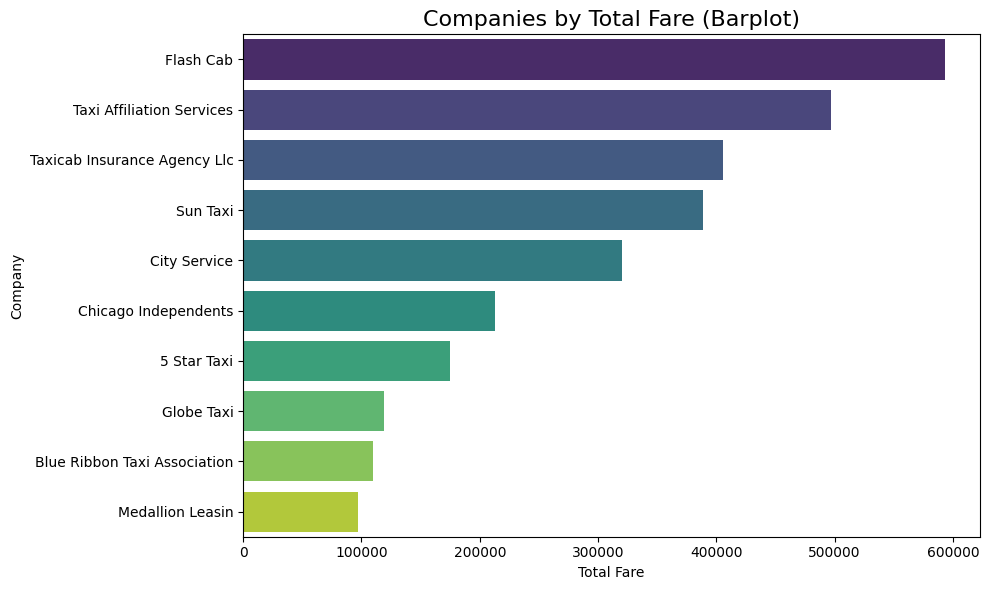

In [32]:
# Visualization 1: barplot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='total_fare', y='company_name', data=df, palette='viridis')
plt.title('Companies by Total Fare (Barplot)', fontsize=16)
plt.xlabel('Total Fare')
plt.ylabel('Company')
plt.tight_layout()
plt.show()



In [37]:
! pip list

Package            Version
------------------ -----------
asttokens          2.4.1
beautifulsoup4     4.12.3
boto3              1.35.13
botocore           1.35.13
certifi            2024.7.4
charset-normalizer 3.3.2
colorama           0.4.6
comm               0.2.2
contourpy          1.3.0
cycler             0.12.1
debugpy            1.8.5
decorator          5.1.1
exceptiongroup     1.2.2
executing          2.0.1
fonttools          4.53.1
idna               3.7
ipykernel          6.29.5
ipython            8.26.0
jedi               0.19.1
jmespath           1.0.1
jupyter_client     8.6.2
jupyter_core       5.7.2
kiwisolver         1.4.7
matplotlib         3.9.2
matplotlib-inline  0.1.7
nest-asyncio       1.6.0
numpy              2.0.1
packaging          24.1
pandas             2.2.2
parso              0.8.4
pillow             10.4.0
pip                24.2
platformdirs       4.2.2
prompt_toolkit     3.0.47
psutil             6.0.0
pure_eval          0.2.3
Pygments           2.18.0
pypar